In [48]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

In [106]:
class GMM:
    def __init__(self, k, max_iter = 100):
        # initializing the number of clusters, maximum iterations, log likelihoods and log likelihood
        self.k = k
        self.max_iter = max_iter
        self.log_likelihoods = []
        self.log_likelihood = 0.0
    
    def predict_proba(self, X):
        # predicting the probabilities of the X dataset
        likelihood = np.zeros((self.n, self.k))
        for i in range(self.k):
            distribution = multivariate_normal(mean=self.mu[i], cov=self.sigma[i], allow_singular=True)
            likelihood[:,i] = distribution.pdf(X)

        numerator = likelihood * self.pi
        # print(numerator)
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        # print(denominator)
        self.log_likelihood = np.sum(np.log(denominator))
        weights = numerator / denominator
#         print(weights)
        return weights
        
    def e_step(self, X):
        # E-Step: updating weights and phi for the current mu and sigma values
        self.weights = self.predict_proba(X)
        self.pi = self.weights.mean(axis=0)
    
    def m_step(self, X):
        # M-Step: updating mu and sigma for the current phi and weights values
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()
            self.mu[i] = (X * weight).sum(axis=0) / total_weight
            self.sigma[i] = np.cov(X.T, aweights=(weight/total_weight).flatten(), bias=True)

    def fit(self, X, epi=1e-6):
        # initializing the pi, mu, sigma and weights with random values
        self.n, self.m = X.shape
        self.pi = np.full(shape = self.k, fill_value=1/self.k)
        self.weights = np.full(shape = (self.n, self.k), fill_value=1/self.k)
#         print(self.weights)
        
        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        self.mu = [ X[row_index, :] for row_index in random_row ]
        self.sigma = [np.cov(X.T) for l in range(self.k)]
        
        # performing E-step and M-step for fixed no of iterations or till convergence
        prev_log_likelihood = self.log_likelihood
        for iteration in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)

            current_log_likelihood = self.log_likelihood
            if abs(current_log_likelihood - prev_log_likelihood) < epi:
                break
            self.log_likelihoods.append(current_log_likelihood)
            prev_log_likelihood = current_log_likelihood
            
    def predict(self, X):
        # predicting the labels of the X dataset
        weights = self.predict_proba(X)
        return np.argmax(weights, axis=1)

    def get_parameters(self):
        # getting the parameters of the model
        return (self.mu, self.sigma)
    
    def get_log_likelihood(self, X):
        # calculating log likelihood of the X dataset
        log_likelihood = 0.0
        for x in X:
            likelihoods = []
            for component in range(self.k):
                # Calculate the probability density for each component
                pdf = multivariate_normal.pdf(x, mean=self.mu[component], cov=self.sigma[component], allow_singular=True)
                likelihoods.append(pdf * self.pi[component])
            # Sum the likelihoods over components for this sample and take the logarithm
            log_likelihood += np.log(np.sum(likelihoods))

        return log_likelihood

    def aic(self, X):
        # calculating aic score of the X dataset
        log_likelihood = self.log_likelihood
    
        n_parameters = self.k * ((self.m **2  - self.m)/2 + 2*self.m + 1) - 1
        aic_score = -2 * log_likelihood + 2*n_parameters
        return aic_score
    
    def bic(self, X):
        # calculating bic score of the X dataset
        log_likelihood = self.log_likelihood        
        # n_parameters = self.k * (self.m **2 + self.m +1) 
        n_parameters = self.k * ((self.m **2  - self.m)/2 + 2*self.m + 1) - 1
        bic_score = -2*log_likelihood + np.log(self.n)*n_parameters
        return bic_score

In [107]:
# reading in the dataset 
data = pd.read_csv("SMAI-Dataset-customer-dataset/data.csv")
data.head()

,Index,Gender,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,0,67,2,124670,1,2
1,1,1,1,22,1,150773,1,2
2,2,0,0,49,1,89210,0,0
3,3,0,0,45,1,171565,1,1
4,4,0,0,53,1,149031,1,1


In [108]:
X = data.drop('Index', axis=1)
X = X.to_numpy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [109]:
pca = PCA(n_components = 2)
pca.fit(X_scaled)
X_transformed = pca.transform(X_scaled)

In [111]:
n_clusters = 5
gmm = GMM(k=n_clusters, max_iter = 200)
gmm.fit(X_scaled)
clusters = gmm.predict(X_scaled)

In [1]:
# plotting the log likelihood vs iterations
# # print(len(gmm.log_likelihoods))
# k = [x for x in range(len(gmm.log_likelihoods))]

# plt.figure(figsize=(8,6))
# plt.plot(k, gmm.log_likelihoods)
# plt.xlabel('Iterations')
# plt.ylabel('Log Likelihood')
# plt.title('Log Likelihood vs Iterations')
# plt.show()

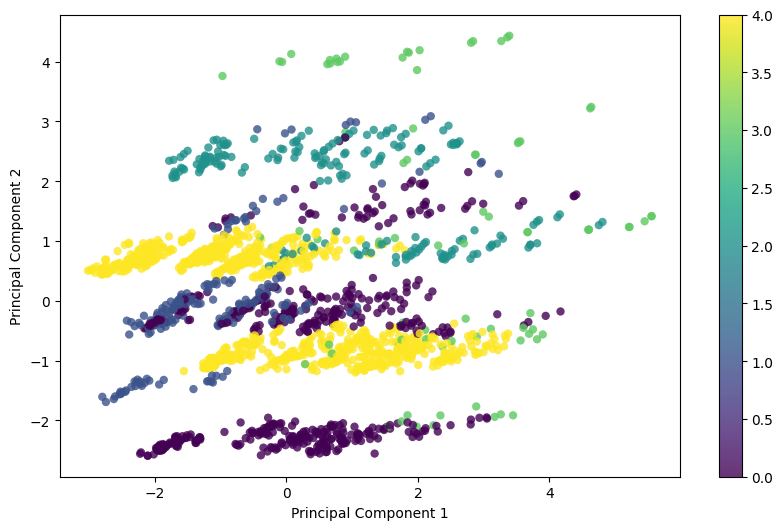

In [89]:
x1 = X_transformed[:, 0]
x2 = X_transformed[:, 1]

plt.figure(figsize = (10, 6))
plt.scatter(x1, x2, c=clusters, edgecolor="none", alpha=0.8, cmap='viridis', label=clusters)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar()
plt.show()

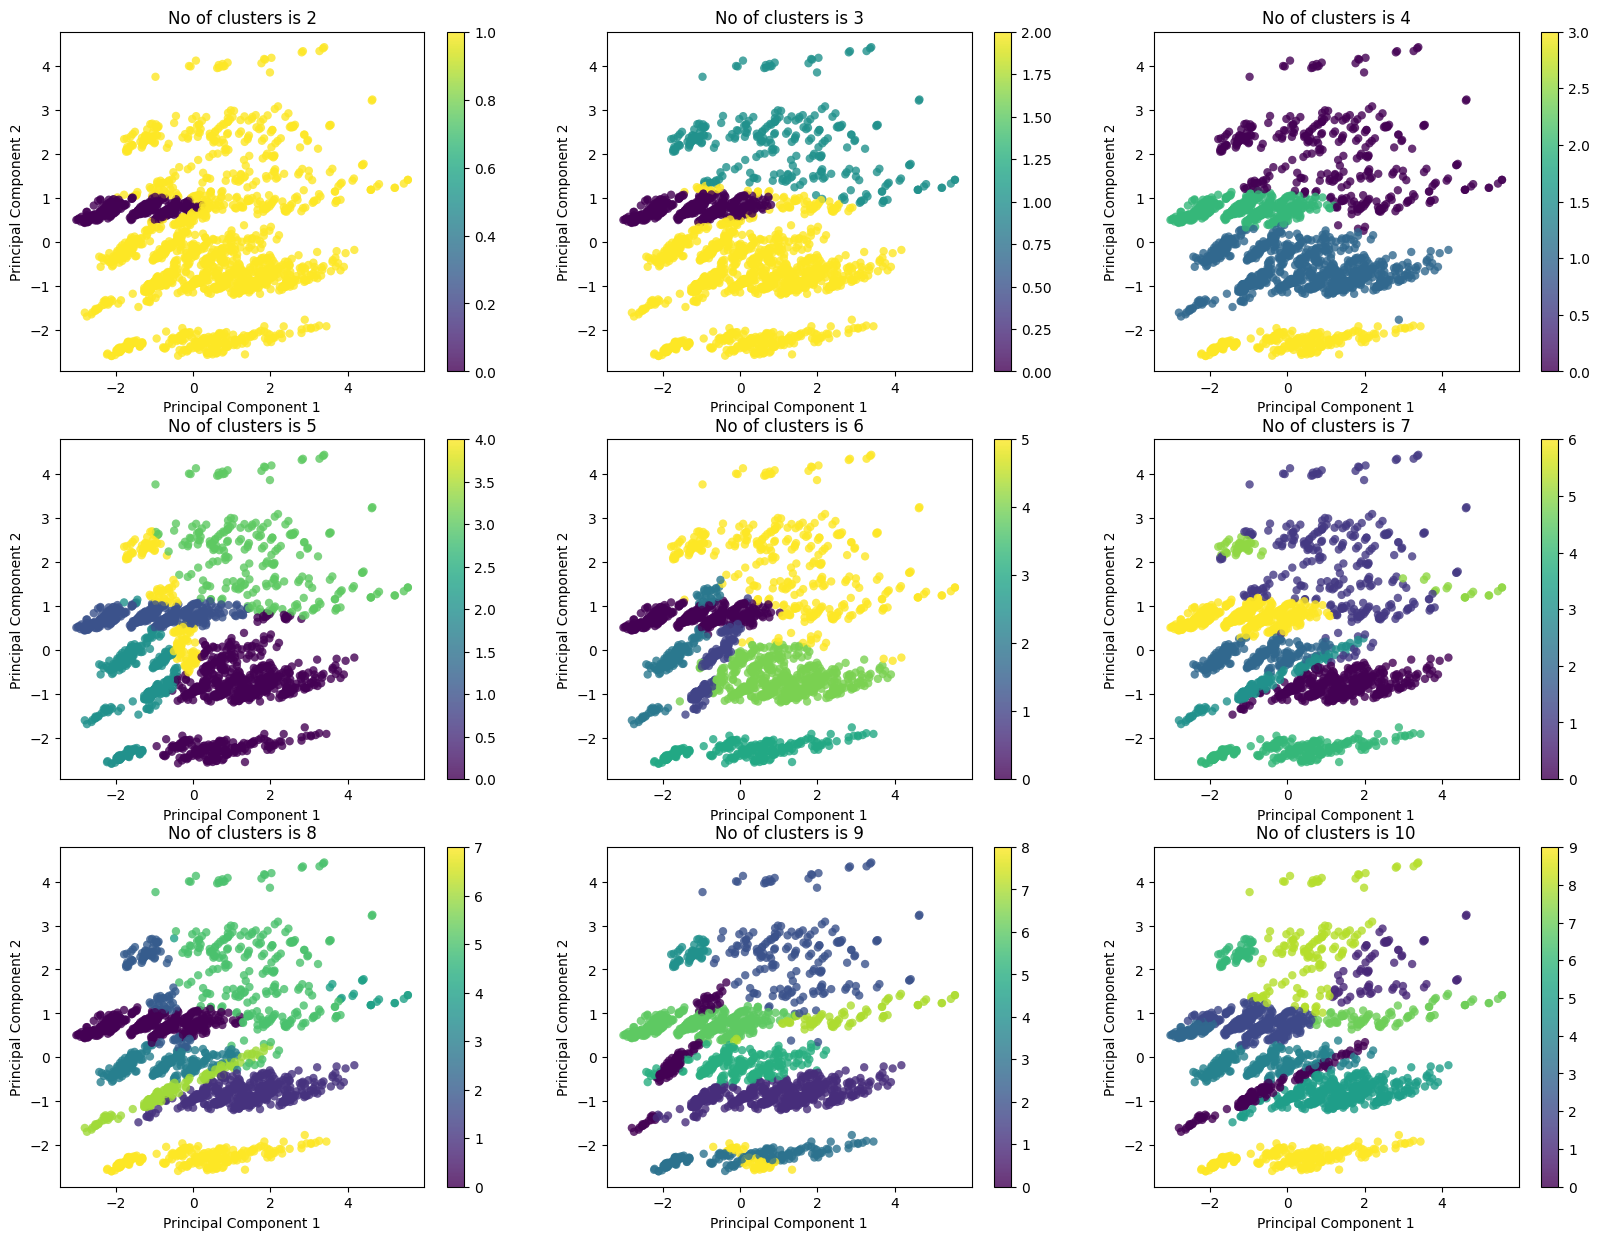

In [90]:
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette_scores_customer = []

i=0
plt.figure(figsize = (20, 15))
for n in n_clusters:
    gmm = GMM(k=n, max_iter = 200)
    gmm.fit(X_transformed)
    clusters = gmm.predict(X_transformed)
    silhouette_scores_customer.append(silhouette_score(X_transformed, clusters))
    
    x1 = X_transformed[:, 0]
    x2 = X_transformed[:, 1]

    plt.subplot(3, 3, n_clusters.index(n)+1)
    plt.scatter(x1, x2, c=clusters, edgecolor="none", alpha=0.8, cmap='viridis', label=clusters)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")    
    plt.title(f"No of clusters is {n}")
    plt.colorbar()
    i = i+1

# plt.colorbar()

Text(0, 0.5, 'Silhouette Score')

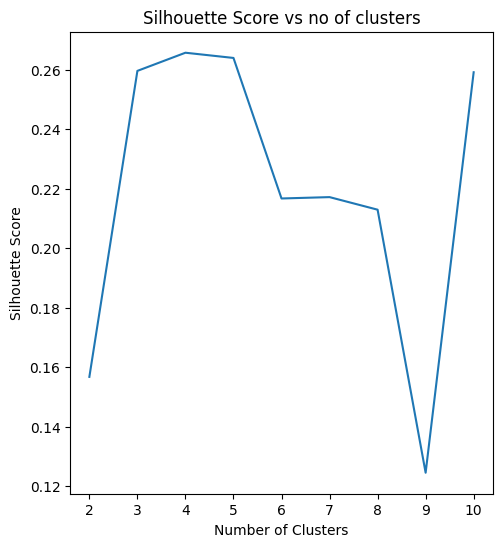

In [91]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(n_clusters, silhouette_scores_customer)
plt.title('Silhouette Score vs no of clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plotting the silhouette score for different no of cluster, we get the optimal cluster as 4 for this customer dataset. From the graphs, we can observe that the optimal clusters comes out to be 4.

In [92]:
# Load the wine dataset
wine = load_wine()
X, y = wine.data, wine.target

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [93]:
# Reducing it to two components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [94]:
# finding the bic, aic, silhouette scores for different no of clusters for GMM Clustering
bic_scores = []
aic_scores = []
bic_scores_gmm = []
aic_scores_gmm = []
silhouette_scores_gmm = []
silhouette_scores_kmeans = []
max_clusters = 10

for n_clusters in range(2, max_clusters + 1):
    # gmm = GaussianMixture(n_components=n_clusters)
    # gmm.fit(X_scaled)
    # bic_scores.append(gmm.bic(X_scaled))
    # aic_scores.append(gmm.aic(X_scaled))
    gmm_ = GMM(k=n_clusters, max_iter = 100)
    gmm_.fit(X_scaled)
    bic_scores_gmm.append(gmm_.bic(X_scaled))
    aic_scores_gmm.append(gmm_.aic(X_scaled))

    clusters = gmm_.predict(X_scaled)
    silhouette_scores_gmm.append(silhouette_score(X_scaled, clusters))

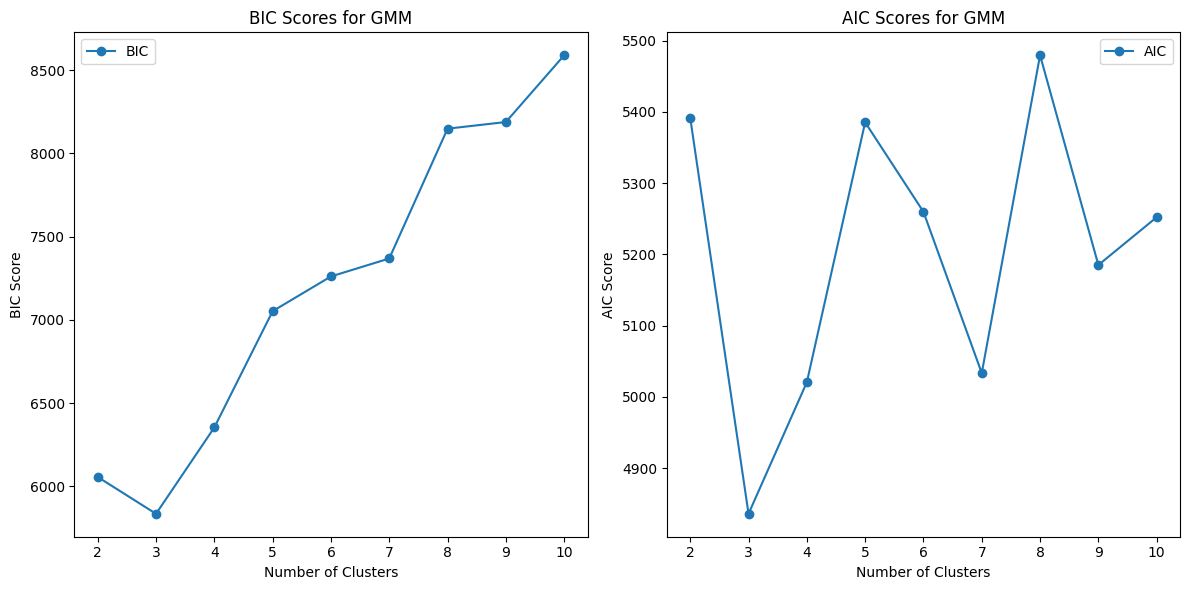

In [95]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_clusters + 1), bic_scores_gmm, marker='o', linestyle='-', label='BIC')
plt.title('BIC Scores for GMM')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC Score')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters + 1), aic_scores_gmm, marker='o', linestyle='-', label='AIC')
plt.title('AIC Scores for GMM')
plt.xlabel('Number of Clusters')
plt.ylabel('AIC Score')
plt.legend()

plt.tight_layout()
plt.show()

From the above graphs of AIC and BIC score, we can observe the score comes out least for n_cluster = 3. So the optimal no of cluster the dataset can be divided into is 3. Therefore we apply gmm for 3 components on the dataset.

In [96]:
# finding the silhouette scores for different no of clusters for KMeans Clustering
for n_clusters in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X_scaled)
    labels = kmeans.labels_
    silhouette_scores_kmeans.append(silhouette_score(X_scaled, labels))

c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.

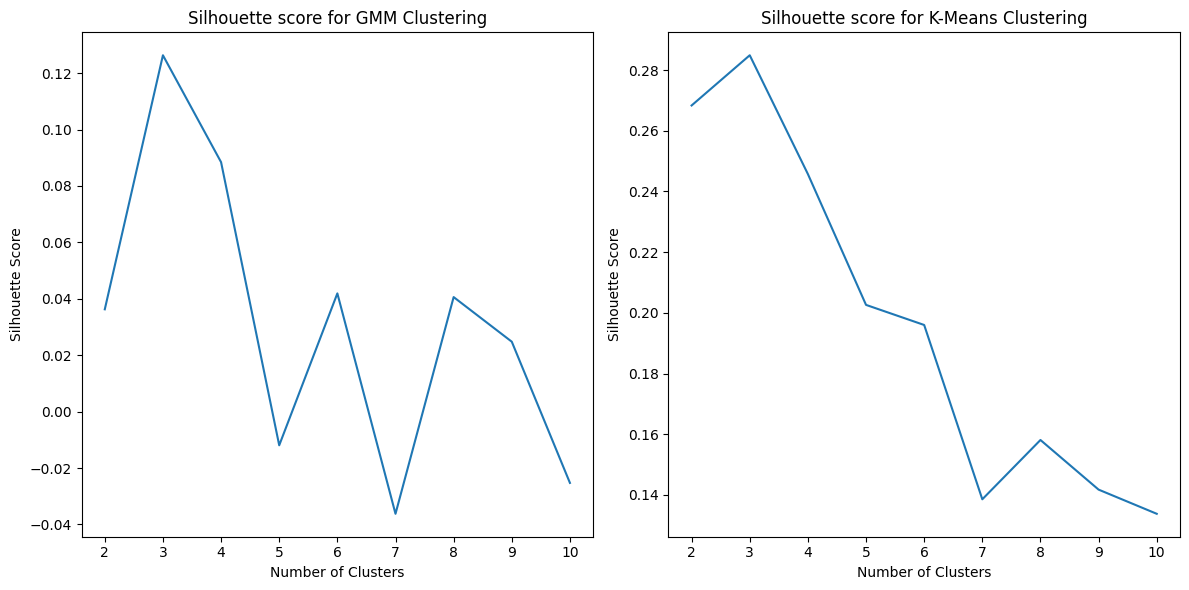

In [97]:
# plotting the silhouette scores for different no of clusters for GMM and KMeans Clustering
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_clusters + 1), silhouette_scores_gmm)
plt.title('Silhouette score for GMM Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters + 1), silhouette_scores_kmeans)
plt.title('Silhouette score for K-Means Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

From the above plot of silhouette score for GMM clustering and K-Means Clustering, we observe that in both the case the score is maximum in case of 3 clusters. So we apply Gmm clustering and kmeans clustering for 3 components

In [103]:
gmm = GMM(k=3, max_iter=500)
# gmm = GaussianMixture(n_components=3)
gmm.fit(X_pca)
labels = gmm.predict(X_pca)

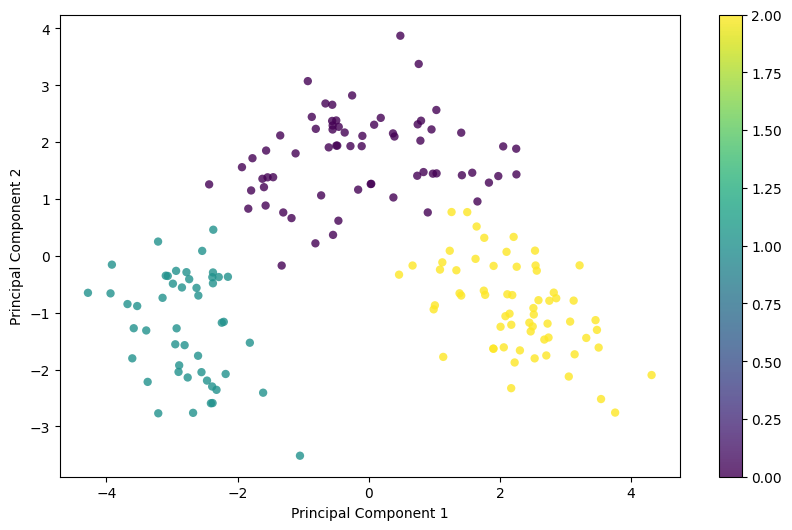

In [104]:
x1 = X_pca[:, 0]
x2 = X_pca[:, 1]

plt.figure(figsize = (10, 6))
# plt.scatter(x1, x2, c=labels, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("cool", 3))
plt.scatter(x1, x2, c=labels, edgecolor="none", alpha=0.8, cmap='viridis', label=labels)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar()
plt.show()

In [100]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X_pca)
labels = kmeans.labels_

c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


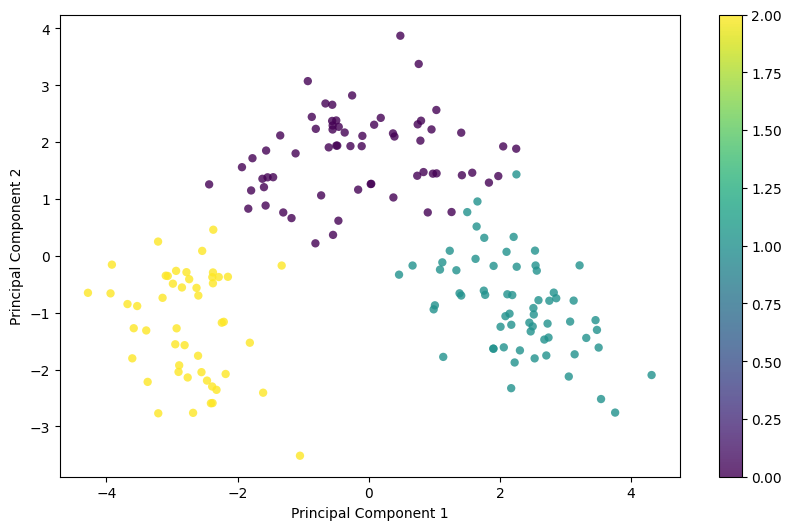

In [101]:
x1 = X_pca[:, 0]
x2 = X_pca[:, 1]

plt.figure(figsize = (10, 6))
plt.scatter(x1, x2, c=labels, edgecolor="none", alpha=0.8, cmap='viridis', label=labels)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar()
plt.show()